In [1]:
import tensorflow as tf
import tensorflow.keras.optimizers
import tensorflow.keras.metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
from datetime import date, datetime, timedelta
import xarray as xr
import netCDF4 as nc
from ndays import numOfDays
import glob
import calendar
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import math


2025-01-17 21:48:20.048636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737150500.058926 2313774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737150500.062164 2313774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 21:48:20.074430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define domain and time period
# date is supposed to change automatically
current_date = '202501172100'


#--------------------------------
current_year = current_date[0:4]
current_month = current_date[4:6]
current_day = current_date[6:8]
t = 3 #numOfDays

# cords of interest
start_lat = -20 #5 # 5 
end_lat = -5 #21 #10
start_lon = 25 #-10
end_lon = 55 #0


In [3]:
# get native MSG grid (core)
coords_filename = glob.glob('/prj/Africa_cloud/geoloc/*.npz')[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_latlon = np.load(coords_filename)
mlon = msg_latlon['lon']
mlat = msg_latlon['lat']

# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]


cores = np.zeros((t,len(lat[:,1]),len(lon[1,:])),dtype=float)
tir = np.zeros((t,len(lat[:,1]),len(lon[1,:])),dtype=float)
time_core = np.zeros((t)) 

In [4]:
def _create_mean_filter(half_num_rows, half_num_columns, num_channels):
    """Creates convolutional filter that computes mean.

    M = number of rows in filter
    N = number of columns in filter
    C = number of channels

    :param half_num_rows: Number of rows on either side of center.  This is
        (M - 1) / 2.
    :param half_num_columns: Number of columns on either side of center.  This
        is (N - 1) / 2.
    :param num_channels: Number of channels.
    :return: weight_matrix: M-by-N-by-C-by-C numpy array of filter weights.
    """

    num_rows = 2 * half_num_rows + 1
    num_columns = 2 * half_num_columns + 1
    weight = 1. / (num_rows * num_columns)

    return np.full(
        (num_rows, num_columns, num_channels, num_channels), weight,
        dtype=np.float32
    )

def FSS_loss(target_tensor, prediction_tensor):
    
    half_window_size_px=2
    use_as_loss_function=True 
    #mask_matrix
    function_name=None
    test_mode=False
    """Fractions skill score (FSS).

    M = number of rows in grid
    N = number of columns in grid

    :param half_window_size_px: Number of pixels (grid cells) in half of
        smoothing window (on either side of center).  If this argument is K, the
        window size will be (1 + 2 * K) by (1 + 2 * K).
    :param use_as_loss_function: Boolean flag.  FSS is positively oriented
        (higher is better), but if using it as loss function, we want it to be
        negatively oriented.  Thus, if `use_as_loss_function == True`, will
        return 1 - FSS.  If `use_as_loss_function == False`, will return just
        FSS.
    :param mask_matrix: M-by-N numpy array of Boolean flags.  Grid cells marked
        "False" are masked out and not used to compute the loss.
    :param function_name: Function name (string).
    :param test_mode: Leave this alone.
    :return: loss: Loss function (defined below).
    """

    weight_matrix = _create_mean_filter(
        half_num_rows=half_window_size_px,
        half_num_columns=half_window_size_px, num_channels=1
    )
       
    """Computes loss (fractions skill score).

        :param target_tensor: Tensor of target (actual) values.
        :param prediction_tensor: Tensor of predicted values.
        :return: loss: Fractions skill score.
    """

    smoothed_target_tensor = K.conv2d(
        x=target_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    smoothed_prediction_tensor = K.conv2d(
        x=prediction_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    actual_mse = K.mean(
        (smoothed_target_tensor - smoothed_prediction_tensor) ** 2
    )
    reference_mse = K.mean(
        smoothed_target_tensor ** 2 + smoothed_prediction_tensor ** 2
    )

    if use_as_loss_function:
        return actual_mse / reference_mse

    return 1. - actual_mse / reference_mse

    if function_name is not None:
        loss.__name__ = function_name


In [5]:
from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

tf.config.run_functions_eagerly(True)

In [6]:
##### Define input shape
image_height= 512
image_width= 512   #
num_channels= 3    #    

modelFile= '../../pkl_files/zambia/trained_models/4hr_using_1hr/Feb/ZA_Jan_Feb_trained_model_2005_to_2019.h5'
unet_model = tf.keras.models.load_model(modelFile, compile=False,custom_objects={'loss': FSS_loss})

unet_model.compile(optimizer=tensorflow.keras.optimizers.Adam(),
                  loss=FSS_loss,
                  metrics=[tf.keras.metrics.Accuracy()])


I0000 00:00:1737150502.131667 2313774 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1028 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:02:00.0, compute capability: 8.6


In [7]:
# load files
current_date_int = datetime.strptime(current_date, '%Y%m%d%H%M')
to_date=datetime.strptime(str(current_date), '%Y%m%d%H%M')
to_minus_1hr_date=current_date_int-timedelta(hours=1)
to_minus_1hr_date= to_minus_1hr_date.strftime('%Y%m%d%H%M')
to_minus_2hr_date=current_date_int-timedelta(hours=2)
to_minus_2hr_date= to_minus_2hr_date.strftime('%Y%m%d%H%M')

dates_of_interest = [to_minus_2hr_date,to_minus_1hr_date,str(current_date)]
    
dir_name = '/prj/nflics/real_time_data/'+current_year+'/'+current_month.zfill(2)+'/'+current_day.zfill(2)+'/' 
    
list_of_files=[]                
for a in range(0,len(dates_of_interest),1):
    dates_of_interest_curr = dates_of_interest[a]
    list_of_files.append(dir_name+'IR_108_BT_'+dates_of_interest_curr[0:4]+dates_of_interest_curr[4:6]+dates_of_interest_curr[6:8]+'_'+dates_of_interest_curr[8:]+'_eumdat.nc')

# read in tir data
for l in range(0,len(list_of_files),1): 
    tir_filename = list_of_files[l]
    if os.path.exists(tir_filename):
        ds = xr.open_dataset(tir_filename).squeeze() 
        tir_temp =  ds['ir108_bt'].values  #/10000
        tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = int(dates_of_interest[l])  #int(tir_filename[-15:-3])


In [8]:
num_frames= 3   # 
t0= 1  #1   
a= 11
b= -25

ind = np.where(cores>0)
cores[ind] = 1 
cores_t_0 = cores[:,a:,:b]
tir_t_0 = tir[:,a:,:b]
ind_tir = np.where(tir_t_0>-0.01)
tir_t_0[ind_tir] = 0
tir_t_0[np.isnan(tir_t_0)] = 0
tir_t_0 = np.round(tir_t_0/-173,4)


prediction_time = time_core*0
for i in range(0,len(time_core)):
    time_core_dt = datetime.strptime(dates_of_interest[i], '%Y%m%d%H%M')
    prediction_time_temp = (time_core_dt+timedelta(hours=4)).strftime('%Y%m%d%H%M')
    prediction_time[i] = int(prediction_time_temp)


# Define input shape
image_height= len(tir_t_0[1,:,1]) #lat
image_width= len(tir_t_0[1,1,:]) #lon
num_channels= 3 #  core at t0-, core at t0-1,  

x_pred= np.zeros((1,image_height,image_width, num_channels))
x_pred[:,:,:,0]= tir_t_0[0,:]
x_pred[:,:,:,1]= tir_t_0[1,:]
x_pred[:,:,:,2]= tir_t_0[2,:]

time_of_day_pred= np.zeros((1,image_height,image_width,1))
time_of_day = float(str(prediction_time[-1])[-6:])/2345
time_of_day_pred[:,:,:,:]=np.round(np.sin(time_of_day*math.pi),2)

predicted_frames= np.round(np.squeeze(unet_model.predict([x_pred,time_of_day_pred])),2)


/home/jawahm/miniforge3/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
I0000 00:00:1737150504.036169 2313774 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


In [9]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom,plot_label):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=False);   # adds latlon grid lines
    xl.xlabels_bottom = True   ## labels off
    xl.ylabels_left =  True
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label(plot_label)
    

202501180100.0


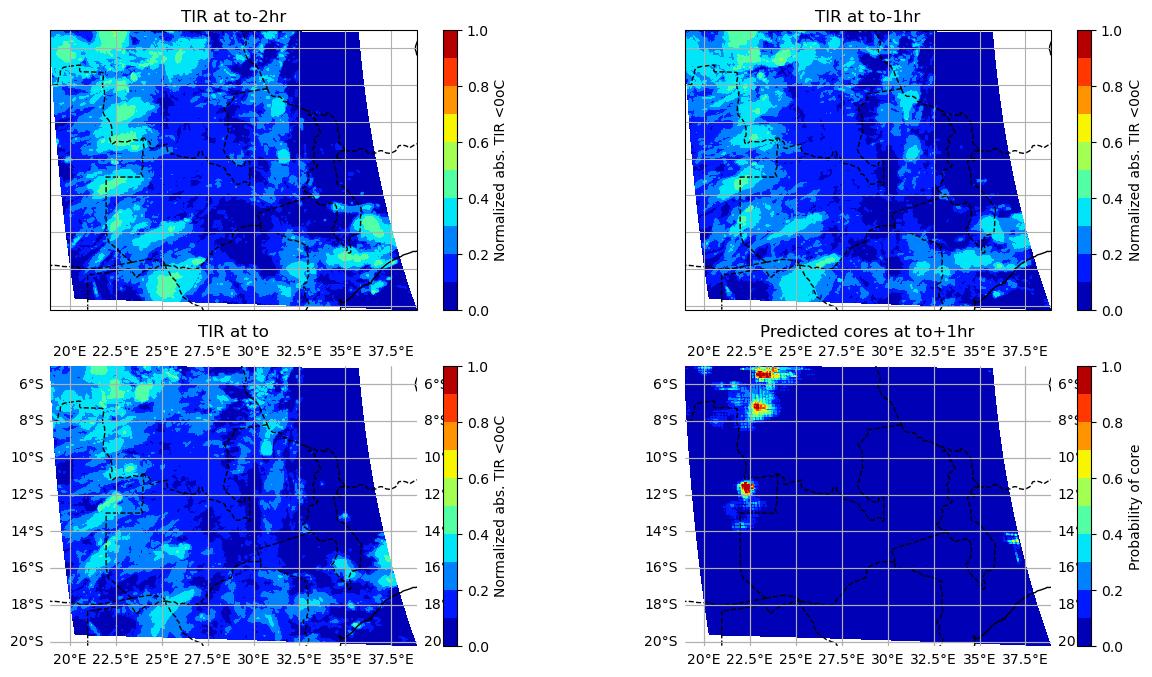

In [10]:
data = np.zeros((4,image_height,image_width))
data[0] = np.squeeze(x_pred[:,:,:,0])
data[1] = np.squeeze(x_pred[:,:,:,1])
data[2] = np.squeeze(x_pred[:,:,:,2])
data[3] = predicted_frames
titles = ['TIR at to-2hr','TIR at to-1hr','TIR at to','Predicted cores at to+1hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.5, 1],np.arange(0,1.05,0.1)]
labels=['Normalized abs. TIR <0oC', 'Probability of core']

fig, axes = plt.subplots(2, 2, figsize=(15, 8),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[a:,:b], lat[a:,:b], data[idx],  title=titles[idx] ,levels_custom= levels_custom[2],plot_label=labels[0])

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[a:,:b], lat[a:,:b], data[idx+2],  title=titles[idx+2] ,levels_custom= levels_custom[2],plot_label=labels[idx])
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_bottom = False   ## labels off
    xl.ylabels_left =  True    #ax.set_title(titles[idx+3])
    ax.axis("off")
  
# Print information and display the figure.
print(prediction_time[2])
plt.show()